<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-END-Program/blob/main/09-%20HandsOn%203/NarrativeQA/NarrativeQA_dataset_Learning_Phrase_Repr_RNN_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The NarrativeQA Reading Comprehension Challenge - RNN Seq2Seq Encoder Decoder solution with Learning Phrase Representation

### NarrativeQA dataset

#### Files
* documents.csv - contains document_id, set, kind, story_url, story_file_size, wiki_url, wiki_title, story_word_count, story_start, story_end. The word count is approximate after some basic cleanup and tokenization.

* third_party/wikipedia/summaries.csv - contains document_id, set, summary, summary_tokenized. The summaries are from Wikipedia.

* qaps.csv - contains document_id, set, question, answer1, answer2, question_tokenized, answer1_tokenized, answer2_tokenized.
download_stories.sh - script to download the stories.

* compare.sh - compare downloaded story's file size to the document size we had. (At the time of publication, all stories have <3.5% file difference (except one), likely due to punctuation encoding.)

Learnings-

1. The decoder takes the context vector (generated from encoder) along with embedded input token and previous hidden state to predict hidden state (s_t)
2. The context vector is fed to the linear layer along with hidden output to predict the next token.

3. Train, test and val split was done as per the set division provided in the dataset. Train, test, val splits do not share documents. Hence, their information is not leaked. Test loss observed = 5.2 (Perplexity score=183)

In [ ]:
!git clone https://github.com/deepmind/narrativeqa.git

Cloning into 'narrativeqa'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), done.


### Necessary packages

In [ ]:
# Packages
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load dataset

Load dataset and split into train, valid and test. We are picking question and answer1 columns to predict the seq2seq translations.

In [ ]:
df_qaps = pd.read_csv('/content/narrativeqa/qaps.csv')
print(df_qaps.shape)
print("Columns of qaps: ",df_qaps.columns)
df_qaps.head()

(46765, 8)
Columns of qaps:  Index(['document_id', 'set', 'question', 'answer1', 'answer2',
       'question_tokenized', 'answer1_tokenized', 'answer2_tokenized'],
      dtype='object')


,document_id,set,question,answer1,answer2,question_tokenized,answer1_tokenized,answer2_tokenized
0,0025577043f5090cd603c6aea60f26e236195594,test,Who is Mark Hunter?,He is a high school student in Phoenix.,A loner and outsider student with a radio stat...,Who is Mark Hunter ?,He is a high school student in Phoenix .,A loner and outsider student with a radio stat...
1,0025577043f5090cd603c6aea60f26e236195594,test,Where does this radio station take place?,It takes place in Mark's parents basement.,"Phoenix, Arizona",Where does this radio station take place ?,It takes place in Mark s parents basement .,"Phoenix , Arizona"
2,0025577043f5090cd603c6aea60f26e236195594,test,Why do more students tune into Mark's show?,Mark talks about what goes on at school and in...,Because he has a thing to say about what is ha...,Why do more students tune into Mark s show ?,Mark talks about what goes on at school and in...,Because he has a thing to say about what is ha...
3,0025577043f5090cd603c6aea60f26e236195594,test,Who commits suicide?,Malcolm.,Malcolm.,Who commits suicide ?,Malcolm .,Malcolm .
4,0025577043f5090cd603c6aea60f26e236195594,test,What does Paige jam into her microwave?,She jams her medals and accolades.,Her award medals,What does Paige jam into her microwave ?,She jams her medals and accolades .,Her award medals


In [ ]:
df_qaps.loc[df_qaps['document_id'] == '0025577043f5090cd603c6aea60f26e236195594']

,document_id,set,question,answer1,answer2,question_tokenized,answer1_tokenized,answer2_tokenized
0,0025577043f5090cd603c6aea60f26e236195594,test,Who is Mark Hunter?,He is a high school student in Phoenix.,A loner and outsider student with a radio stat...,Who is Mark Hunter ?,He is a high school student in Phoenix .,A loner and outsider student with a radio stat...
1,0025577043f5090cd603c6aea60f26e236195594,test,Where does this radio station take place?,It takes place in Mark's parents basement.,"Phoenix, Arizona",Where does this radio station take place ?,It takes place in Mark s parents basement .,"Phoenix , Arizona"
2,0025577043f5090cd603c6aea60f26e236195594,test,Why do more students tune into Mark's show?,Mark talks about what goes on at school and in...,Because he has a thing to say about what is ha...,Why do more students tune into Mark s show ?,Mark talks about what goes on at school and in...,Because he has a thing to say about what is ha...
3,0025577043f5090cd603c6aea60f26e236195594,test,Who commits suicide?,Malcolm.,Malcolm.,Who commits suicide ?,Malcolm .,Malcolm .
4,0025577043f5090cd603c6aea60f26e236195594,test,What does Paige jam into her microwave?,She jams her medals and accolades.,Her award medals,What does Paige jam into her microwave ?,She jams her medals and accolades .,Her award medals
5,0025577043f5090cd603c6aea60f26e236195594,test,What does Mark do with his radio station?,He dismantles it and attaches it to his mother...,Dismantle it.,What does Mark do with his radio station ?,He dismantles it and attaches it to his mother...,Dismantle it .
6,0025577043f5090cd603c6aea60f26e236195594,test,What does Mark tell the protesting students?,He tells them to make their own future.,That they should make their own future because...,What does Mark tell the protesting students ?,He tells them to make their own future .,That they should make their own future because...
7,0025577043f5090cd603c6aea60f26e236195594,test,Who gets arrested?,Mark and Nora.,Mark and Nora.,Who gets arrested ?,Mark and Nora .,Mark and Nora .
8,0025577043f5090cd603c6aea60f26e236195594,test,What does the radio show cause?,It causes trouble.,It causes much trouble in the community.,What does the radio show cause ?,It causes trouble .,It causes much trouble in the community .
9,0025577043f5090cd603c6aea60f26e236195594,test,Where does Mark Broadcast his station from?,Parent's Basement,At the basement of his home,Where does Mark Broadcast his station from ?,Parent s Basement,At the basement of his home


In [ ]:
df_qaps.groupby('set').agg('count')

,document_id,question,answer1,answer2,question_tokenized,answer1_tokenized,answer2_tokenized
set,,,,,,,
test,10557,10557,10557,10557,10557,10557,10557
train,32747,32747,32747,32747,32747,32747,32747
valid,3461,3461,3461,3461,3461,3461,3461


In [ ]:
df_train_qaps = df_qaps[df_qaps['set'] == 'train'][['question', 'answer1']].reset_index(drop=True)
df_test_qaps = df_qaps[df_qaps['set'] == 'test'][['question', 'answer1']].reset_index(drop=True)
df_valid_qaps = df_qaps[df_qaps['set'] == 'valid'][['question', 'answer1']].reset_index(drop=True)
print("Train set:",df_train_qaps.shape, "Test set:",df_test_qaps.shape, "Valid set:",df_valid_qaps.shape)

Train set: (32747, 2) Test set: (10557, 2) Valid set: (3461, 2)


In [ ]:
df_train_qaps[:5]

,question,answer1
0,Who is Miss Delmer?,the elderly spinster aunt of the Earl de Verse...
1,Who does Arabella Mason wed?,"Ben Keene, Delmar's valet"
2,How does Percival Keene get his name?,"Percival is Captain Delmar's first name, and K..."
3,Who is the bully that steals Percival's lunch?,"his teacher, Mr. O'Gallagher"
4,How does Percival get even with O'Gallagher af...,He sets them on fire with the teacher sitting ...


### Download and load spacy models

This is going to be used for tokenization.

In [ ]:
# Download and load spacy models for EN language. To be used for tokenization.
%%bash
python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
spacy_en = spacy.load('en')

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
tokenize_en("Spacy model for EN is loaded up.")

['Spacy', 'model', 'for', 'EN', 'is', 'loaded', 'up', '.']

### Prepare FIELDS

Defines a datatype together with instructions for converting to Tensor. holds a Vocab object that defines the set of possible values
    for elements of the field and their corresponding numerical representations.

QUESTIONS - Field containing the questions for training.
ANSWERS - Field for prediction.

In [ ]:
QUESTIONS = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)
ANSWERS = Field(tokenize = tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

In [ ]:
print(type(QUESTIONS))
QUESTIONS.__dict__

<class 'torchtext.data.field.Field'>


{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<eos>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<sos>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True}

Create a list of (name, field) pairs as the fields argument. The fields we pass in must be in the same order as the columns

In [ ]:
fields = [('question', QUESTIONS), ('answer1', ANSWERS)]

Convert from pandas to list to torchtext.

In [ ]:
example_train = [data.Example.fromlist([df_train_qaps.question[i],df_train_qaps.answer1[i]], fields) for i in range(df_train_qaps.shape[0])] 
example_valid = [data.Example.fromlist([df_valid_qaps.question[i],df_valid_qaps.answer1[i]], fields) for i in range(df_valid_qaps.shape[0])] 
example_test = [data.Example.fromlist([df_test_qaps.question[i],df_test_qaps.answer1[i]], fields) for i in range(df_test_qaps.shape[0])] 

In [ ]:
# Creating dataset
train_data = data.Dataset(example_train, fields)
valid_data = data.Dataset(example_valid, fields)
test_data = data.Dataset(example_test, fields)

In [ ]:
print(vars(train_data.examples[0]))

{'question': ['who', 'is', 'miss', 'delmer', '?'], 'answer1': ['the', 'elderly', 'spinster', 'aunt', 'of', 'the', 'earl', 'de', 'verseley', 'and', 'captain', 'delmar']}


In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 32747
Number of validation examples: 3461
Number of testing examples: 10557


### Build vocabulary for SRC and TRG

Vocabulary will associate each unique tokens with an index. Only tokens that appear atleast 2 times are considered. Other such words are replaced by < UNK >. Vocab object built on only training examples.

In [ ]:
QUESTIONS.build_vocab(train_data, min_freq = 2)
ANSWERS.build_vocab(train_data, min_freq = 2)

In [ ]:
print("Size of Source vocab: ",len(QUESTIONS.vocab))
print("Size of Target vocab: ",len(ANSWERS.vocab))

Size of Source vocab:  10574
Size of Target vocab:  10695


In [ ]:
vars(QUESTIONS)

{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<eos>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<sos>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True,
 'vocab': <torchtext.vocab.Vocab at 0x7f6f5dba1710>}

In [ ]:
# QUESTIONS.vocab dict has the following keys - freqs(provides word and its frequencies), itos(mapping of integer to string), 
# stoi(mapping of string to its integer) and vectors()
print(QUESTIONS.vocab.__dict__.keys())
QUESTIONS.vocab.__dict__

dict_keys(['freqs', 'itos', 'stoi', 'vectors'])


{'freqs': Counter({'who': 8144,
          'is': 8399,
          'miss': 61,
          'delmer': 1,
          '?': 32754,
          'does': 9780,
          'arabella': 25,
          'mason': 41,
          'we': 32,
          'd': 6,
          'how': 3639,
          'percival': 19,
          'keene': 4,
          'get': 614,
          'his': 2207,
          'name': 1122,
          'the': 19479,
          'bully': 5,
          'that': 1342,
          'steals': 17,
          "'s": 5697,
          'lunch': 8,
          'even': 31,
          'with': 2157,
          "o'gallagher": 1,
          'after': 1467,
          'he': 1464,
          'takes': 88,
          'all': 106,
          'of': 5652,
          'boy': 45,
          'fireworks': 2,
          'convince': 85,
          'pirates': 27,
          'to': 10077,
          'spare': 11,
          'save': 92,
          'captain': 132,
          'delmar': 2,
          'life': 210,
          'what': 13753,
          'shocking': 5,
          'new

### Create iterators for train, valid and test.

BucketIterator is used instead of Standard Iterator. BucketIterator defines an iterator that batches examples of similar lengths together.

Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch.

batch.QUESTIONS - [ (128) , (128), .. 23 times]**bold text**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# TypeError: '<' not supported between instances of 'Example' and 'Example'
# This happens because the dataset iterator from torchtext tries to sort the dataset, which implies comparing two elements. 
# have to provide a sorting function to the constructor of the BucketIterator
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort=False,
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
batch = next(iter(train_iterator))

In [ ]:
print(batch)


[torchtext.data.batch.Batch of size 128]
	[.question]:[torch.cuda.LongTensor of size 25x128 (GPU 0)]
	[.answer1]:[torch.cuda.LongTensor of size 20x128 (GPU 0)]


In [ ]:
# Batch contains question and answer1. Can be accessed as batch.question (tensor) and batch.answer1 (tensor)
# batch.question groups the first element of all sequences in batch of 128, then groups second element of sequence in batch 128.
print(type(batch))
print(batch)
print('Data type of batch.question', type(batch.question))
print("Length of a source sequence", len(batch.question))
print("Length of source at first index. (2 is for <sos>)", len(batch.question[0]))
print("Length of source at last index. (6 - what , 8- does )", len(batch.question[-1]))
print("Values at source first index", batch.question[0])
print(batch.answer1[1])

<class 'torchtext.data.batch.Batch'>

[torchtext.data.batch.Batch of size 128]
	[.question]:[torch.cuda.LongTensor of size 25x128 (GPU 0)]
	[.answer1]:[torch.cuda.LongTensor of size 20x128 (GPU 0)]
Data type of batch.question <class 'torch.Tensor'>
Length of a source sequence 25
Length of source at first index. (2 is for <sos>) 128
Length of source at last index. (6 - what , 8- does ) 128
Values at source first index tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([    0,     8,     6,     8,  7379,   123,     5,     0,  1005,  9541,
           75,   466,     8,     8,   171,    32,  

### Building the Seq2Seq Model
<a name="model"></a>
Using single layered GRU network.

#### Encoder

GRU is that it only requires and returns a hidden state, there is no cell state like in the LSTM.

it takes in a sequence, $X = \{x_1, x_2, ... , x_T\}$, passes it through the embedding layer, recurrently calculates hidden states, $H = \{h_1, h_2, ..., h_T\}$, and returns a context vector (the final hidden state), $z=h_T$.

$$h_t = \text{EncoderGRU}(e(x_t), h_{t-1})$$

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim) 
        
        #no dropout as only one layer!
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]        
        outputs, hidden = self.rnn(embedded) #no cell state!
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden

#### Decoder

Two changes:
1. Instead of the GRU in the decoder taking just the embedded target token, $d(y_t)$ and the previous hidden state $s_{t-1}$ as inputs, it also takes the context vector $z$. 

$$s_t = \text{DecoderGRU}(d(y_t), s_{t-1}, z)$$


The context vector z does not have a subscript. This means we re-use the same context vector returned by the encoder for every decoder time step.

2. Previously, the next token was predicted with linear layer applied on the hidden state output on the top layer.

$$\hat{y}_{t+1}=f(s_t^L)$$

Now, we also pass the embedding of current token, $d(y_t)$ and the context vector, $z$ to the linear layer.

$$\hat{y}_{t+1} = f(d(y_t), s_t, z)$$

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq6.png?raw=1)

hypothetically the decoder hidden states,  st , no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of  yt  to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)

        self.fc_out = nn.Linear(emb_dim + 2 * hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        # input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, emb_dim]

        emb_con = torch.cat((embedded, context), dim=2)
        # emb_con = [1, batch size, emb_dim + hid_dim]

        output, hidden = self.rnn(emb_con, hidden)
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim=1)
        # output = [batch size, emb dim + 2 * hid dim]

        prediction = self.fc_out(output)
        # prediction = [batch_size, output_dim]

        return prediction, hidden 

#### Seq2Seq model

Putting the encoder and decoder together, we get:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

Again, in this implementation we need to ensure the hidden dimensions in both the encoder and the decoder are the same.

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive a `context` vector
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector, $z$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate (either the ground truth next token in the target sequence or the highest predicted next token)

In [ ]:
# build seq2seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder output
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Last hidden state of the encoder is the context
        context = self.encoder(src)

        # context is also used as the initial hidden state of the decoder
        hidden = context

        # fist input to the decoder is <sos> token
        input = trg[0,:]

        for t in range(1, trg_len):
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            # decide of teacher forcing is going to be used
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

### Training the Seq2Seq Model

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [ ]:
INPUT_DIM = len(QUESTIONS.vocab)
OUTPUT_DIM = len(ANSWERS.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

#### Initialize model parameters
Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(0, 0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(0, 0.01)$.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10574, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10695, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=10695, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,297,031 trainable parameters


#### Initialize optimizer and loss function.

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = ANSWERS.vocab.stoi[ANSWERS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

#### TRAIN loop

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        question = batch.question
        answer = batch.answer1
        
        optimizer.zero_grad()
        
        output = model(question, answer)
        
        #answer = [answer len, batch size]
        #output = [answer len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        answer = answer[1:].view(-1)
        
        #answer = [(answer len - 1) * batch size]
        #output = [(answer len - 1) * batch size, output dim]
        
        loss = criterion(output, answer)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#### Eval loop

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            question = batch.question
            answer = batch.answer1
            print

            output = model(question, answer, 0) #turn off teacher forcing

            #answer = [answer len, batch size]
            #output = [answer len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            answer = answer[1:].view(-1)

            #answer = [(answer len - 1) * batch size]
            #output = [(answer len - 1) * batch size, output dim]

            loss = criterion(output, answer)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Model train

In [ ]:
train_loss_all = []
val_loss_all = []

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_loss_all.append(train_loss)
    val_loss_all.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 52s
	Train Loss: 6.065 | Train PPL: 430.386
	 Val. Loss: 5.328 |  Val. PPL: 205.970
Epoch: 02 | Time: 0m 52s
	Train Loss: 5.569 | Train PPL: 262.203
	 Val. Loss: 5.316 |  Val. PPL: 203.580
Epoch: 03 | Time: 0m 52s
	Train Loss: 5.437 | Train PPL: 229.856
	 Val. Loss: 5.306 |  Val. PPL: 201.479
Epoch: 04 | Time: 0m 52s
	Train Loss: 5.237 | Train PPL: 188.085
	 Val. Loss: 5.264 |  Val. PPL: 193.289
Epoch: 05 | Time: 0m 53s
	Train Loss: 5.094 | Train PPL: 163.091
	 Val. Loss: 5.194 |  Val. PPL: 180.177
Epoch: 06 | Time: 0m 53s
	Train Loss: 4.932 | Train PPL: 138.666
	 Val. Loss: 5.146 |  Val. PPL: 171.799
Epoch: 07 | Time: 0m 53s
	Train Loss: 4.757 | Train PPL: 116.420
	 Val. Loss: 5.168 |  Val. PPL: 175.583
Epoch: 08 | Time: 0m 53s
	Train Loss: 4.589 | Train PPL:  98.389
	 Val. Loss: 5.178 |  Val. PPL: 177.286
Epoch: 09 | Time: 0m 53s
	Train Loss: 4.388 | Train PPL:  80.456
	 Val. Loss: 5.249 |  Val. PPL: 190.469
Epoch: 10 | Time: 0m 54s
	Train Loss: 4.156 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.192 | Test PPL: 179.907 |


Train, val loss curve

In [ ]:
import matplotlib.pyplot as plt
def train_test_metrics_graph(train_loss_all, val_loss_all):

    plt.plot(train_loss_all, label="Train Loss")
    plt.plot(val_loss_all, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch curve")

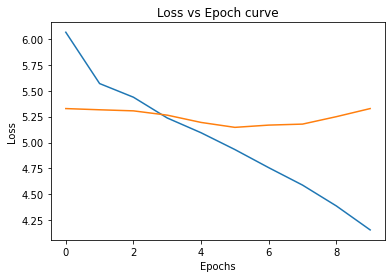

In [ ]:
train_test_metrics_graph(train_loss_all, val_loss_all)